# Convex Hull Continuum Removal

This notebook reads the hyperspectral mosaic, calculates a convex hull and outputs a convex hull continuum removed data set.

In [1]:
# import standard libaries
import os, warnings, subprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# import gis libraries
import rasterio
from rasterio.windows import Window

# import convex hull module from Scipy
from scipy.spatial import ConvexHull

# filter warnings for tidy output
warnings.filterwarnings("ignore")

## 1. Run Convex Hull Removal

This is a pretty slow workflow that runs a pixel-wise convex hull removal processing step inspired by Ben Chi's [*Reading TSG Files*](https://www.fractalgeoanalytics.com/articles/reading-tsg-files/) blogpost.

In [2]:
# set path to mosaic ENVI grid
hsi_fn = r'/storage/gsq_hymap/processed/GSQ_block-d_mosaic_ref.dat'

# set path to output convex hull continuum removed ENVI grid
chull_fn = r'/storage/gsq_hymap/outputs/GSQ_block-d_mosaic_hull.dat'

In [3]:
# open the ENVI
with rasterio.open(hsi_fn,'r') as src:
  # create a metadata file for the output
  meta = src.meta.copy()
  meta.update({'dtype':'int16', 'driver':'ENVI', 'nodata':-999})
  # get a numpy array of the wavelegnths for each band, use band descriptions
  wvl = np.array([float(x.strip('nm')) for x in src.descriptions])
  # open the output file
  with rasterio.open(chull_fn,'w',**meta) as dst:
    # iterate through the native blockwindows (rows in ENVI grids)
    blockwindows = [x for x in src.block_windows()]
    for ji, block in tqdm(blockwindows):
      hsi_window = src.read(window=block)[:,0,:].T    # reshape window to (Npixels, Nwavelengths)
      # iterate through pixels in blockwindow and perform convex hull continuum removal 
      cvxhul_window = hsi_window.copy()
      for i, pix in enumerate(hsi_window):
        if pix[0] != src.nodata: # only consider non-nodata pixels
          fpix = pix.copy()
          fpix[fpix < 0] = 0
          fpix[0], fpix[-1] = -1, -1
          # fpix = np.interp(wvl, wvl[mask_b62], pix[mask_b62])       # linear interpolation to fix weird band 62 values
          cvxhul = ConvexHull(np.vstack([fpix, wvl]).T)             # fit convex hull to fixed spectrum
          vtx = np.sort(cvxhul.vertices)                            # get sorted vertices of the hull
          hull = np.interp(np.arange(wvl.shape[0]), vtx, pix[vtx])  # linear interpolation of hull for all wavelengths 
          cvxhul_window[i] = pix - hull                             # remove hull from spectrum and place in output window
      # write the convex hull removed data to the output file
      dst_out = np.zeros((wvl.shape[0],1,cvxhul_window.shape[0]), dtype=cvxhul_window.dtype)
      dst_out[:,0,:] = cvxhul_window.T
      dst.write(dst_out, window=block)
    # write band descriptions
    for i, d in enumerate(src.descriptions):
      dst.set_band_description(i+1, src.descriptions[i])
    dst.close()
  src.close()

 18%|█▊        | 1279/7285 [09:27<1:27:52,  1.14it/s]

## 2. Validate Results

Plot a random selection of pixels from the raw and convex hull removed data cube to confirm the above has worked.

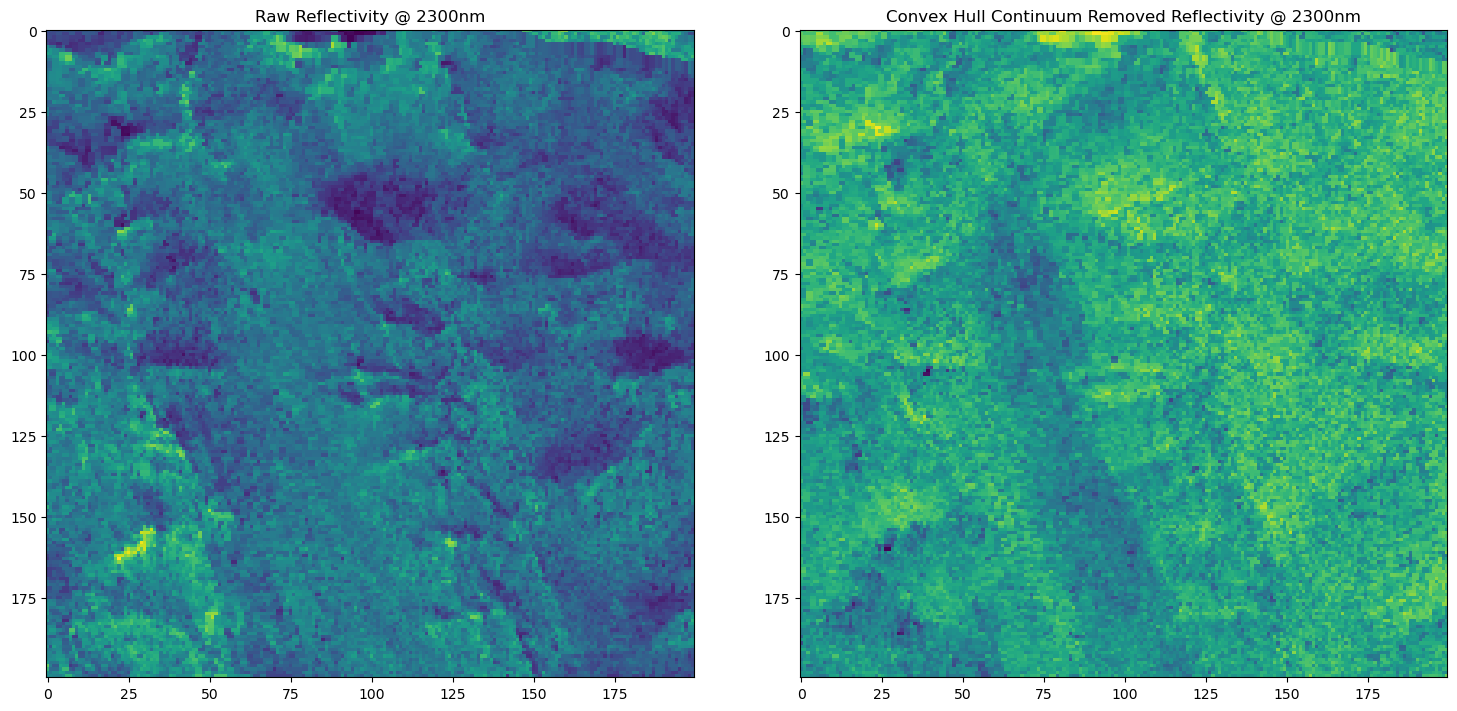

In [6]:
# create a 50 by 50 pixel window from the raw and convex hull mosaics
read_win = Window(4000, 4000, 200, 200)
raw_win = rasterio.open(hsi_fn,'r').read(window=read_win)
cvx_win = rasterio.open(chull_fn,'r').read(window=read_win)
wvl = np.array([float(x.strip('nm')) for x in rasterio.open(chull_fn,'r').descriptions])

# find the wavelength closest to 2300nm
crb_idx = np.argmin(abs(wvl-2300))

# plot both windows
fig, axes = plt.subplots(1,2,figsize=(15,7), constrained_layout=True)
for d, ax, t in zip([raw_win, cvx_win], axes, ['Raw Reflectivity @ 2300nm', 'Convex Hull Continuum Removed Reflectivity @ 2300nm']):
  ax.imshow(d[crb_idx])
  ax.set(title=t)
plt.show()

In [7]:
raw_win = raw_win.reshape((raw_win.shape[0], raw_win.shape[1] * raw_win.shape[2])).T
cvx_win = cvx_win.reshape((cvx_win.shape[0], cvx_win.shape[1] * cvx_win.shape[2])).T
raw_win.shape, cvx_win.shape

((40000, 126), (40000, 126))

In [8]:
raw_win.min()

-68

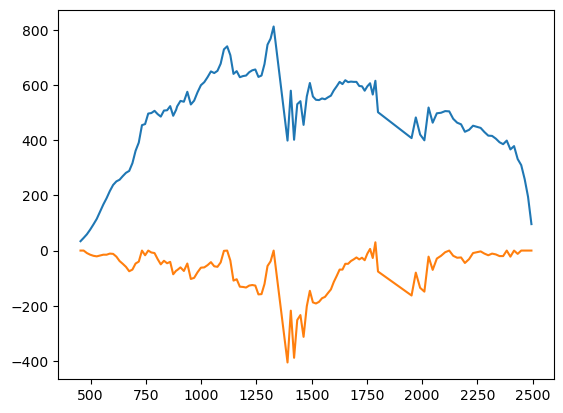

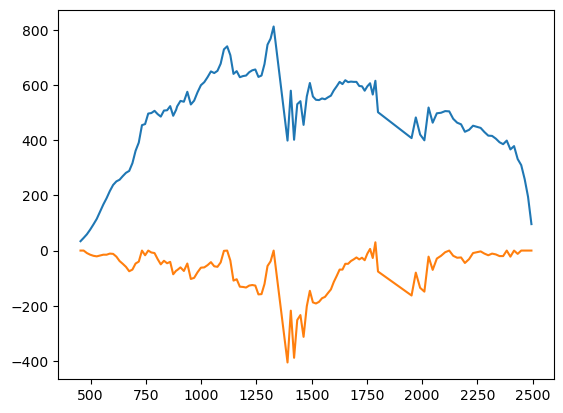

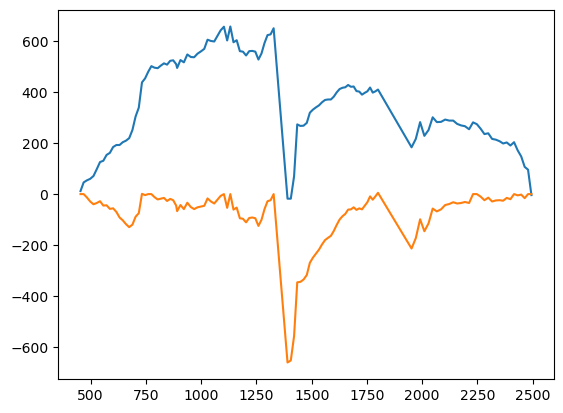

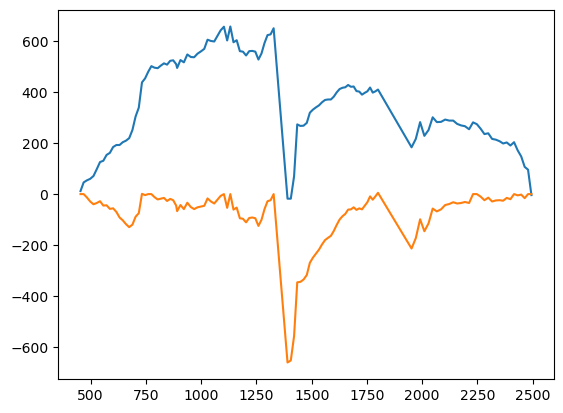

In [9]:
max_pix_idx = np.argwhere(cvx_win[:,crb_idx] > np.percentile(cvx_win[:,crb_idx], 99.99))
max_pix_idx
for i in max_pix_idx.flatten():
  plt.plot(wvl, raw_win[i])
  plt.plot(wvl, cvx_win[i])
  plt.show()

## 3. Calculate Calcite Abundance Index